## APS - PYTHON PARA CIÊNCIA DE DADOS

# Análise do efeito da covid-19 nos países e variáveis relacionadas ao combate à doença

Aluno: Otávio Farhat Fernandes

## Descrição da base:


   A base contém informações sobre quantidade de mortos e casos de covid por país, além de dados quanto aos gastos do governo com saúde per capita, índices de qualidade das instituições (corrupção, eficiência do governo etc.), taxa de obesidade na população, entre outros fatores que podem afetar o combate à Covid em 113 países.

   O objetivo principal é verificar se uma qualidade institucional maior está relacionada a um combate à Covid mais efetivo. A análise busca entender primeiro entender qual a relação entre as diferentes variáveis, como se dá a distribuição entre continentes e mesmo dentro dos países. Em seguida, são montados alguns modelos econométricos para se realizar inferências quanto aos efeitos estudados entre a variável explicada e a explicativa e os outros controles.

   O tema é relevante por poder prover informações sobre quais os canais que devem ser focados para combater a doença.

   A base foi formada a partir de diversas fontes:

  -Our World in Data
  -World Bank
  -Euromonitor
  -ONU
  
  Os dados já estão em formato tidy, então nenhuma transformação mais estrutural foi necessária.

## Importação das Bibliotecas

In [24]:
import numpy as np
import pandas as pd
from scipy.stats import iqr
import matplotlib.pyplot as plt
from plotnine import *
import locale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, roc_auc_score
import patsy
%matplotlib inline

theme_set(theme_bw());

## Importação dos dados

Adicionei a base à minha conta do GitHub. O código pega a base do site diretamente. Todas as variáveis são numéricas, com exceção à variável "continent", que indica o continente da observação.

In [25]:
covid = pd.read_csv("https://raw.githubusercontent.com/otavioffern/An-lise-de-Dados/main/covid_APS_PyCD.csv", sep = None, decimal = ",")
#covid = covid.dropna()
covid.head()
#covid.describe()

C:\Users\ferna\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.


,﻿Geography,Population Density,year,code,Healthspd,Government Spending Score,Population,Obesity,continent,date,...,total_deaths,aged_65_older,total_cases_per_million,total_deaths_per_million,stringency_index,Rural Population,institutional_index,percentage_rural_pop,institutional_index_new,turismo
0,Afghanistan,58.3,2019,AFG,7.6,80.3,38041800,5.1,Asia,30/11/2020,...,1763.0,2.581,1160.148,44.257,12.04,28244500.0,-4.113828,0.742460,0.006505,0.0
1,Armenia,103.9,2019,ARM,58.0,79.0,2957700,22.1,Asia,30/11/2020,...,2164.0,11.232,45524.991,729.079,NaN,1087900.0,-0.548544,0.367820,0.443195,1894.0
2,Azerbaijan,120.8,2019,AZE,46.5,59.5,9981500,21.7,Asia,30/11/2020,...,1392.0,6.018,11852.873,136.159,69.91,4633800.0,-1.946761,0.464239,0.271936,3170.0
3,Bangladesh,1252.6,2019,BGD,18.3,94.5,163046200,4.0,Asia,30/11/2020,...,6644.0,5.098,2795.684,39.951,80.09,102058800.0,-2.378168,0.625950,0.219095,323.0
4,Bhutan,20.0,2019,BTN,65.3,71.6,763100,6.9,Asia,30/11/2020,...,NaN,4.885,525.708,NaN,64.81,445600.0,1.027348,0.583934,0.636217,316.0


Turismo está com valores como "object". Substituíndo por float e os valores que são 0 são substituídos por NA.

In [70]:
covid["turismo"] = covid.turismo.astype(float)

covid = covid.assign(turismo_certo = lambda _: np.where(_.turismo != 0, _.turismo, np.nan))
                          
covid.isna().sum()

﻿Geography                    0
Population Density            0
year                          0
code                          0
Healthspd                     0
Government Spending Score     0
Population                    0
Obesity                       0
continent                     0
date                          0
total_cases                   0
total_deaths                  6
aged_65_older                 0
total_cases_per_million       0
total_deaths_per_million      6
stringency_index              4
Rural Population              1
institutional_index           0
percentage_rural_pop          1
institutional_index_new       0
turismo                       0
turismo_certo                15
mortes_pad                    6
inst_ext                      0
eficient                      6
dtype: int64

## Dicionário de Variáveis

A variável de qualidade institucional varia entre 0 e 1 e foi formada a partir de outras 6 variáveis do Worldwide Governance Indicator (WGI), do Banco Mundial. Cada variável mede um "tema" diferente. Temos por exemplo, Eficiência do Governo, Voice and Accountability, Rule of Law etc.
Essas variáveis são importantes para definir se um país possui instituições inclusivas ou extrativas, um tema bem analisado por Acemoglu e Robinson no livro "Por Que Nações Fracassam".

In [27]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ﻿Geography                 123 non-null    object 
 1   Population Density         123 non-null    float64
 2   year                       123 non-null    int64  
 3   code                       123 non-null    object 
 4   Healthspd                  123 non-null    float64
 5   Government Spending Score  123 non-null    float64
 6   Population                 123 non-null    int64  
 7   Obesity                    123 non-null    float64
 8   continent                  123 non-null    object 
 9   date                       123 non-null    object 
 10  total_cases                123 non-null    int64  
 11  total_deaths               117 non-null    float64
 12  aged_65_older              123 non-null    float64
 13  total_cases_per_million    123 non-null    float64

# Freedman-Diaconis Rule

Utilizei a fórmula para que os histogramas tenham a melhor visualização possível.

In [28]:
fdhealth = 2 * iqr(covid.Healthspd) / len(covid)**(1/3) 
fdindex = 2 * iqr(covid.institutional_index_new) / len(covid)**(1/3)

# Número de Países por continente

In [29]:
covid.value_counts("continent").to_frame("n").reset_index()

,continent,n
0,Europe,35
1,Asia,32
2,Africa,29
3,North America,13
4,Oceania,7
5,South America,7


Conta a quantidade de países por continente, ordena em ordem crescente. Vemos que existem mais dados para a Europa. Oceania e América do Sul são os que menos possuem observações. Não existem dados para países da América Central.

Abaixo, pd.Categorical faz a variável continent ser categórica. Ordena as barras por quantidade de observações.

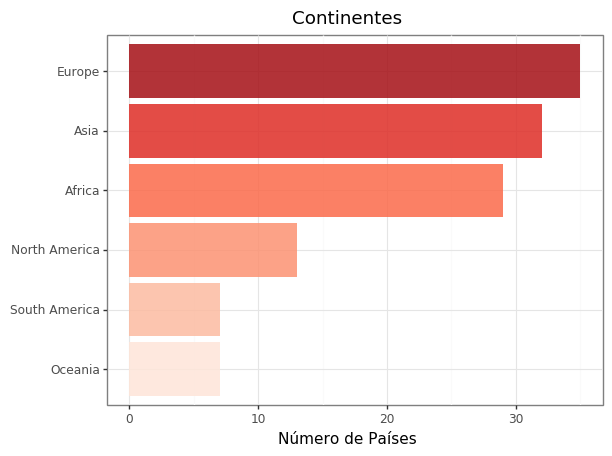

<ggplot: (113055435805)>

In [30]:
(covid.value_counts("continent").to_frame("n").reset_index()
      .sort_values("n")
      .assign(continent = lambda _: pd.Categorical(_.continent, _.continent))
      .pipe(lambda _: ggplot(_, aes(x = "continent", y = "n", fill = "continent")) +
                          geom_col(alpha = 0.85) +
                          labs(x = "", y = "Número de Países", title = "Continentes") +
                          scale_fill_brewer(palette = "Reds") +
                          theme(legend_position = "none") +
                          coord_flip()))

# Distribuição de Qualidade Institucional por País

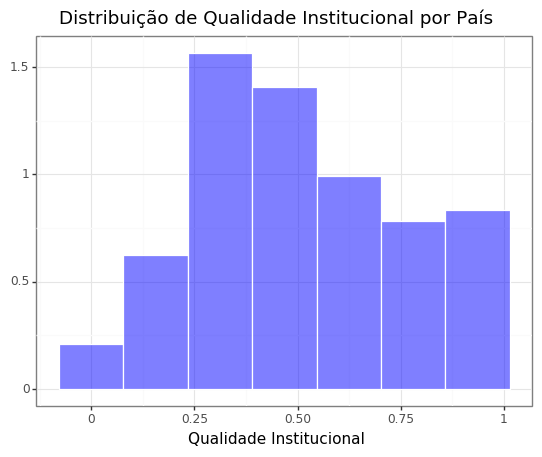

<ggplot: (-9223371923799355932)>

In [31]:
(ggplot(covid, aes(x = "institutional_index_new", y = "stat(density)")) +
     geom_histogram(binwidth = fdindex, fill = "blue", color = "white", alpha = 0.5) +
     labs(x = "Qualidade Institucional", y = "", title = "Distribuição de Qualidade Institucional por País"))

Há uma maior concentração de Qualidade Institucional entre 0,25 e 0,5. Abaixo, quebrando a visualização em continentes, verificamos que a Europa possui uma concentração maior de países com Qualidade Institucional alta, o que faz sentido, dado que existem muitos países desenvolvidos na região. A África é o continente que parece possuir Qualidade Institucional mais concentrada em níveis baixos, o que também faz sentido.

# Distribuição de Qualidade Institucional por Continente

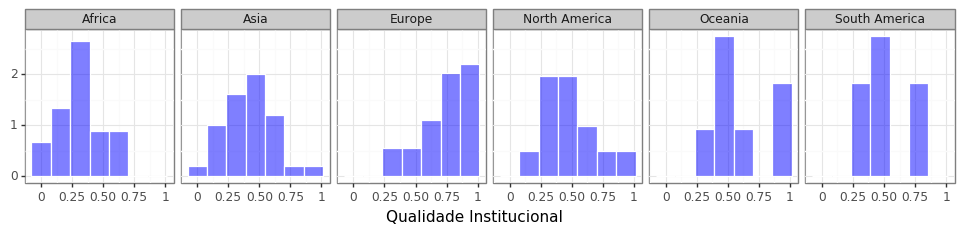

<ggplot: (-9223371923799635701)>

In [32]:
(ggplot(covid, aes(x = "institutional_index_new", y = "stat(density)")) +
     geom_histogram(binwidth = fdindex, fill = "blue", color = "white", alpha = 0.5) +
     labs(x = "Qualidade Institucional", y = "") +
     facet_wrap("~ continent", nrow = 1) +
     theme(figure_size = (12, 2)))

A imagem abaixo, que reúne os histogramas dos continentes, demonstra o que já foi afirmado acima.

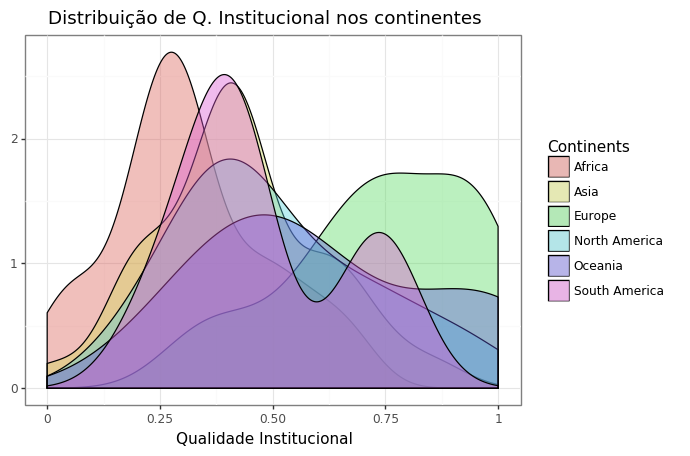

<ggplot: (-9223371923799345706)>

In [33]:
(ggplot(covid, aes(x = "institutional_index_new", fill = "continent")) +
     geom_density(alpha = 0.4) +
     labs(x = "Qualidade Institucional", y = "", fill = "Continents", title = "Distribuição de Q. Institucional nos continentes"))

Box plot de mortes totais por milhão organizado pela mediana para cada continente. Até a data de coleta dos dados (01/12/2020), a América do Sul era a região que mais estava sofrendo com a covid-19, pelos países contidos na base de dados.

C:\Users\ferna\Anaconda3\lib\site-packages\plotnine\layer.py:324: PlotnineWarning: stat_boxplot : Removed 6 rows containing non-finite values.


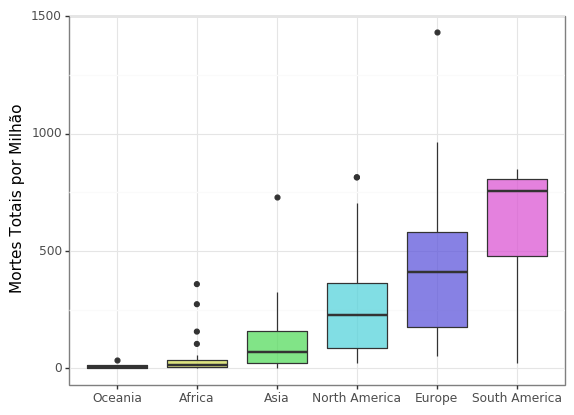

<ggplot: (113055419817)>

In [34]:
continent_order = covid.groupby("continent").total_deaths_per_million.apply(np.mean).sort_values().index

(covid.assign(continent = lambda _: pd.Categorical(_.continent, continent_order))
      .pipe(lambda _: ggplot(_, aes(x = "continent", y = "total_deaths_per_million", fill = "continent")) +
                          geom_boxplot(alpha = 0.75) +
                          labs(x = "", y = "Mortes Totais por Milhão", title = "") +
                          theme(legend_position = "none")))

# Distanciamento

Stringency_index mostra uma medida que representa a severidade das restrições impostas pelo governo do país quanto à circulação de pessoas. Inclui, por exemplo, medidas de quantidade de escolas fechadas. Espera-se que, quanto maior a severidade do lockdown, menos as mortes, pois o país terá uma transmissão da doença menor, o que ocupa menos camas de hospitais. Utilizo o logaritmo das duas variáveis. A linha preta é a que minimiza o erro quadrático médio.

C:\Users\ferna\Anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 9 rows containing missing values.


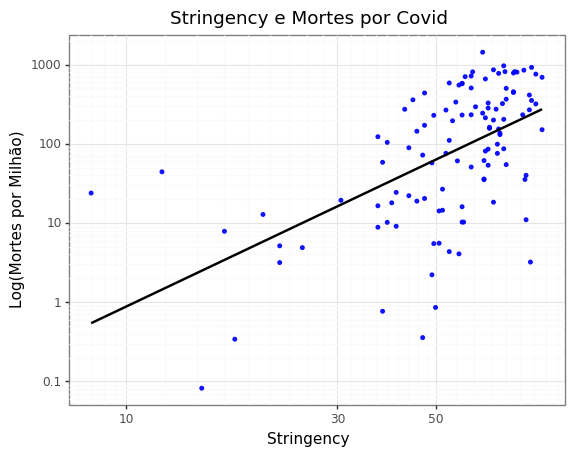

<ggplot: (-9223371923802743920)>

In [35]:
(ggplot(covid, aes(x = "stringency_index", y = "total_deaths_per_million")) +
     geom_point(color = "blue", size = 1, alpha = 0.9) +
     geom_smooth(color = "black", method = "lm", alpha = .5, se = False)+
     scale_x_log10() +
     scale_y_log10() +
     labs(x = "Stringency", y = "Log(Mortes por Milhão)", title = "Stringency e Mortes por Covid"))

Há uma relação positiva entre as duas variáveis, diferente do esperado. A explicação para isso é dada na seção de Inferências.

# Tentando controlar por quantidade de idosos

Países com maiores taxas de idosos na população (idade maior que 65 anos) podem ter sofrido mais mortes por covid, dado que é uma doença com alta taxas de mortalidade nessas faixas de idade. Para controlar por isso, divido as mortes por milhão pela porcentagem da população com mais de 65 anos no país.

C:\Users\ferna\Anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 9 rows containing missing values.


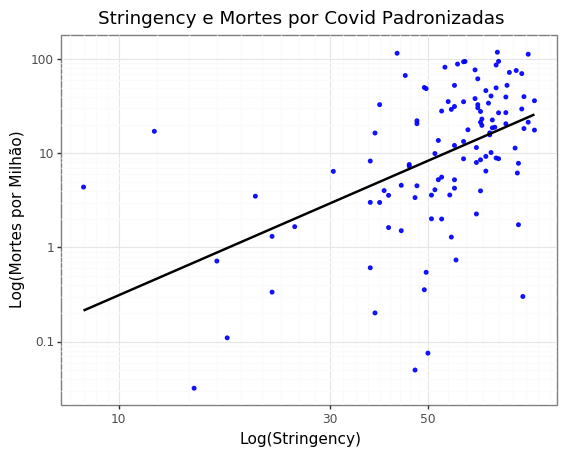

<ggplot: (113053185842)>

In [36]:
covid["mortes_pad"] = (covid["total_deaths_per_million"]/covid["aged_65_older"])
(ggplot(covid, aes(x = "stringency_index", y = "mortes_pad")) +
     geom_point(color = "blue", size = 1, alpha = 0.9) +
     geom_smooth(color = "black", method = "lm", alpha = .5, se = False)+
     scale_x_log10() +
     scale_y_log10() +
     labs(x = "Log(Stringency)", y = "Log(Mortes por Milhão)", title = "Stringency e Mortes por Covid Padronizadas"))

Não parece haver muita diferença em comparação ao gráfico anterior.

# Stringency por continente

C:\Users\ferna\Anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 9 rows containing missing values.


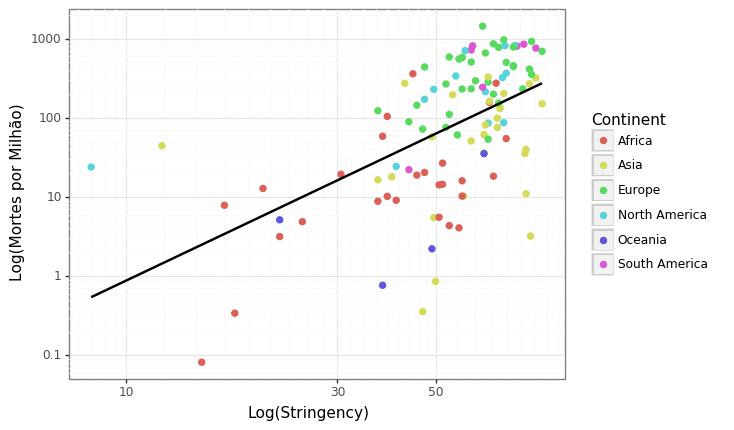

<ggplot: (-9223371923801206605)>

In [37]:
(ggplot(covid, aes(x = "stringency_index", y = "total_deaths_per_million")) +
     geom_point(aes(color = "continent"), size = 2) +
     geom_smooth(color = "black", method = "lm", alpha = .5, se = False)+
     scale_x_log10() +
     scale_y_log10() +
     labs(x = "Log(Stringency)", y = "Log(Mortes por Milhão)",
                  color = "Continent", title = ""))

O continente do país parece ser importante para explicar mortes por covid. Podemos ver que a África e Europa parecem ter níveis similares de log(strigency), mas a Europa tem níveis mais elevados de mortes.

# Relação entre Gastos com Saúde e Covid

A variável de gastos com saúde per capita é de 2019 para se evitar simultaneidade com mortes totais, pois um país com mais mortes deve elevar seus gastos com saúde. 

C:\Users\ferna\Anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 6 rows containing missing values.


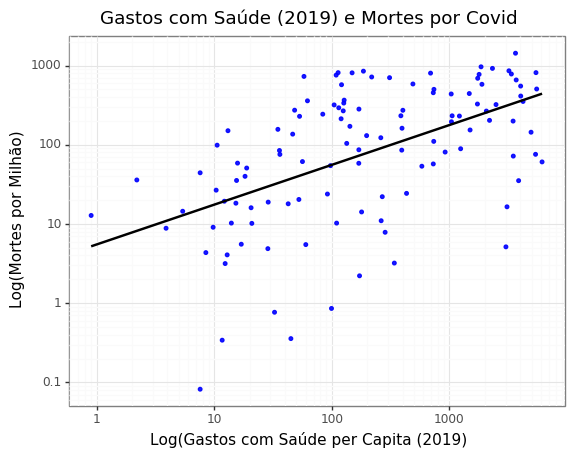

<ggplot: (-9223371923801196775)>

In [38]:
(ggplot(covid, aes(x = "Healthspd", y = "total_deaths_per_million")) +
     geom_point(color = "blue", size = 1, alpha = 0.9) +
     geom_smooth(color = "black", method = "lm", alpha = .5, se = False)+
     scale_x_log10() +
     scale_y_log10() +
     labs(x = "Log(Gastos com Saúde per Capita (2019)", y = "Log(Mortes por Milhão)",
          title = "Gastos com Saúde (2019) e Mortes por Covid"))

Temos uma relação positiva entre as duas variáveis, o contrário do que se era esperado. Porém, há um problema de variáveis omitidas, o que causaria a estimativa de gastos com saúde em uma regressão ser viesada. Podemos relacionar isso mais à frente com a variável de turismo,  por exemplo.

# Estudando os casos mais extremos; primeiro e último quartil de qualidade institucional

Criei duas variáveis que marcam quais países estão no primeiro e no último quartil de qualidade institucional. Caso elas ficam mais "unidas" em gráficos de dispersão, pode ser um indicador que qualidade institucional é um fator importante para explicar alguns fatores.

Depois, crio uma coluna que classifica o primeiro quartil de QI como país com instituições "Extrativas", e no último quartil, como "Inclusivas", seguindo a análise de Acemoglu e Robinson em seu livro.

In [39]:
prim_quan = np.quantile(covid["institutional_index_new"], .25)
ulti_quan = np.quantile(covid["institutional_index_new"], .75)
covid = covid.assign(inst_ext = lambda _: np.where(_.institutional_index_new < prim_quan, "Mais Extrativa",
                                           np.where(_.institutional_index_new > ulti_quan, "Mais Inclusiva", "Between")))


C:\Users\ferna\Anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 9 rows containing missing values.


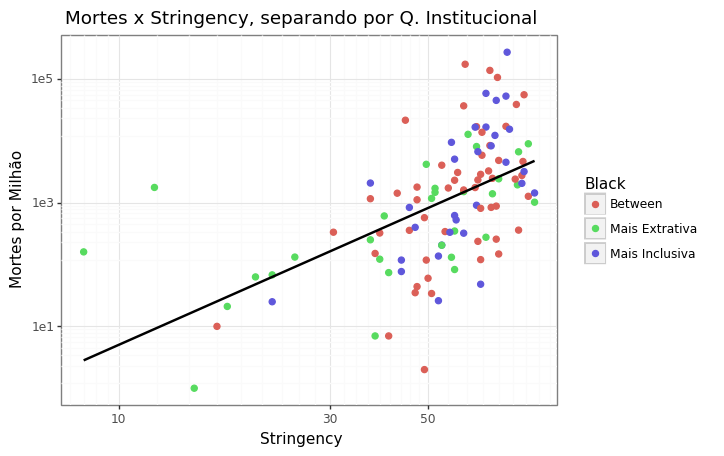

<ggplot: (-9223371923801489927)>

In [40]:
(ggplot(covid, aes(x = "stringency_index", y = "total_deaths")) +
     geom_point(aes(color = "inst_ext"), size = 2) +
     geom_smooth(color = "black", method = "lm", alpha = .8, se = False)+
     scale_x_log10() +
     scale_y_log10() +
     labs(x = "Stringency", y = "Mortes por Milhão", color = "Black", title = "Mortes x Stringency, separando por Q. Institucional"))

Não parece que ter instituições inclusivas ou mais extrativas afeta o combate à covid quanto à variável stringency.

# Mortes por Covid por Milhão e Qualidade Institucional

C:\Users\ferna\Anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 6 rows containing missing values.


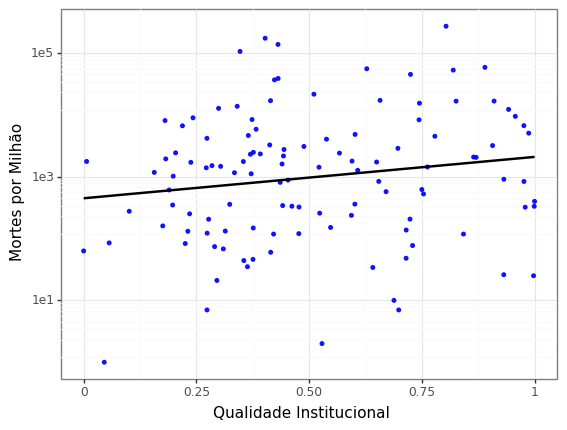

<ggplot: (113055724278)>

In [41]:
(ggplot(covid, aes(x = "institutional_index_new", y = "total_deaths")) +
     geom_point(color = "blue", size = 1, alpha = 0.9) +
     geom_smooth(color = "black", method = "lm", alpha = .5, se = False)+
     scale_y_log10() +
     labs(x = "Qualidade Institucional", y = "Mortes por Milhão", color = "Black", title = ""))

Parece existir uma leve relação positiva entre as duas variáveis, mas de sinal contrário ao que era esperado. Abaixo, padronizo por % de idosos no país, mas a relação não muda muito.

C:\Users\ferna\Anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 6 rows containing missing values.


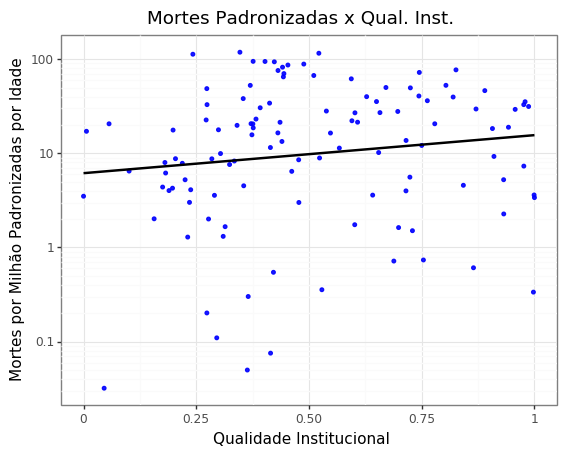

<ggplot: (-9223371923799007253)>

In [42]:
(ggplot(covid, aes(x = "institutional_index_new", y = "mortes_pad")) +
     geom_point(color = "blue", size = 1, alpha = 0.9) +
     geom_smooth(color = "black", method = "lm", alpha = .5, se = False)+
     scale_y_log10() +
     labs(x = "Qualidade Institucional", y = "Mortes por Milhão Padronizadas por Idade",
                                          color = "Continent", title = "Mortes Padronizadas x Qual. Inst."))

# Gastos com Saúde, separando por qualidade institucional

Parece que ter ou não qualidade institucional alta afeta muito as mortes por milhão no caso de gastos com saúde. A única coisa que podemos verificar é que países com instituições inclusivas gastam mais com saúde, e vice-versa. Porém, isso está mais relacionado ao nível de desenvolvimento do país.

C:\Users\ferna\Anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 6 rows containing missing values.


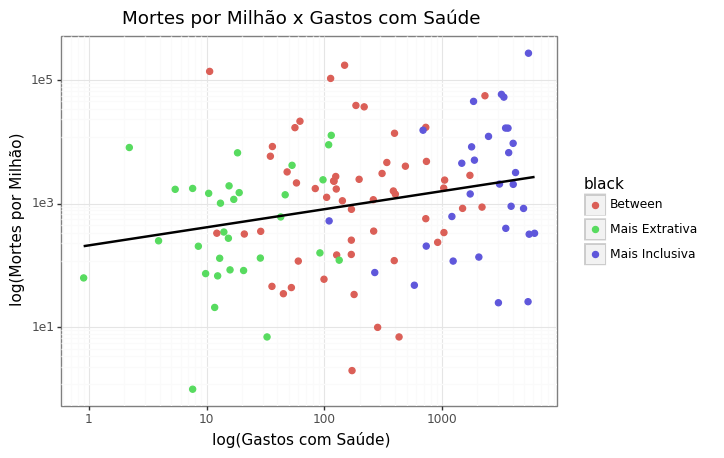

<ggplot: (-9223371923799332615)>

In [43]:
(ggplot(covid, aes(x = "Healthspd", y = "total_deaths")) +
     geom_point(aes(color = "inst_ext"), size = 2) +
     geom_smooth(color = "black", method = "lm", alpha = .5, se = False)+
     scale_x_log10() +
     scale_y_log10() +
     labs(x = "log(Gastos com Saúde)", y = "log(Mortes por Milhão)", color = "black", title = "Mortes por Milhão x Gastos com Saúde"))

## Eficiência

A colune "eficient" tenta medir a eficiência no combate à covid medindo a quantidade de casos que se traduziram em mortes no país.

C:\Users\ferna\Anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 6 rows containing missing values.


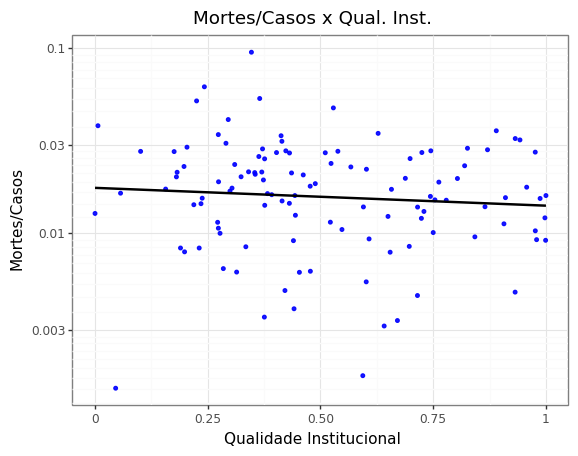

<ggplot: (113053186140)>

In [47]:
covid = covid.assign(eficient = lambda _: covid["total_deaths_per_million"]/covid["total_cases_per_million"])

covid.head()
(ggplot(covid, aes(x = "institutional_index_new", y = "eficient")) +
     geom_point(color = "blue", size = 1, alpha = 0.9) +
     geom_smooth(color = "black", method = "lm", alpha = .5, se = False)+
     scale_y_log10() +
     labs(x = "Qualidade Institucional", y = "Mortes/Casos",
                                          color = "black", title = "Mortes/Casos x Qual. Inst."))

Agora, parece que países com maior qualidade institucional obtiveram maior eficiência no combate à covid.

# Turismo

Países que recebiam mais turistas no início da pandemia sofreram mais no início por conta de terem sofrido mais transmissões.

C:\Users\ferna\Anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning: geom_point : Removed 20 rows containing missing values.


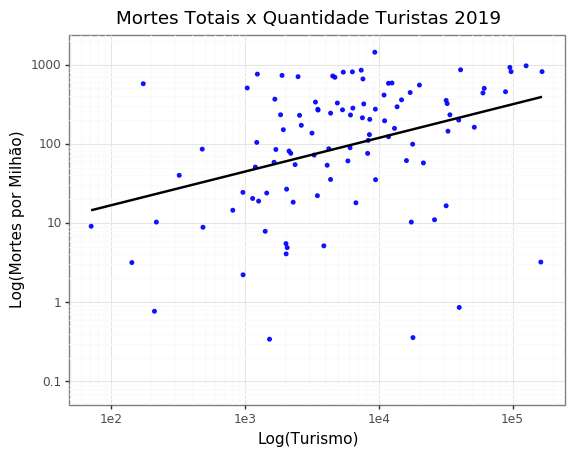

<ggplot: (113053859532)>

In [45]:
(ggplot(covid, aes(x = "turismo_certo", y = "total_deaths_per_million")) +
     geom_point(color = "blue", size = 1, alpha = 0.9) +
     geom_smooth(color = "black", method = "lm", alpha = 1, se = False)+
     scale_y_log10() +
     scale_x_log10() +
     labs(x = "Log(Turismo)", y = "Log(Mortes por Milhão)",
                                          color = "black", title = "Mortes Totais x Quantidade Turistas 2019"))

## Regressão Linear - Inferência

O modelo estuda a relação entre mortes totais por milhão, qualidade institucional, stringency, Gastos com saúde per capita e obesidade.

$$ \large{ {Y}_{i} = \beta_{0} + \beta_{1} \ln{{X}_{1i}} + \beta_{2} {X}_{2i} + \beta_{3} \ln{{X}_{3i}} + \beta_{4} \ln{{X}_{4i}} + \epsilon_{i}} $$
$${}$$
$${}$$
$$ \begin{split}
{Y}_{i} &=\texttt{total_deaths_per_million}\\
{X}_{1i} &=\texttt{institutional_index_new}\\
{X}_{2i} &=\texttt{distanciamento}\\
{X}_{3i} &=\texttt{Healthspd}\\
{X}_{4i} &=\texttt{Obesity} 
\end{split}$$

Rodando o modelo de regressão linear

In [49]:
lin_reg = smf.ols("np.log(total_deaths_per_million)	 ~ institutional_index_new + stringency_index + np.log(Healthspd) + Obesity + aged_65_older", covid).fit()

lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     np.log(total_deaths_per_million)   R-squared:                       0.574
Model:                                          OLS   Adj. R-squared:                  0.554
Method:                               Least Squares   F-statistic:                     29.05
Date:                              Mon, 22 Nov 2021   Prob (F-statistic):           1.41e-18
Time:                                      17:35:49   Log-Likelihood:                -191.72
No. Observations:                               114   AIC:                             395.4
Df Residuals:                                   108   BIC:                             411.8
Df Model:                                         5                                         
Covariance Type:                          nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.3568      0.483     -0.739      0.462      -1.314       0.601
institutional_index_new    -0.9224      1.109     -0.832      0.407      -3.121       1.276
stringency_index            0.0415      0.008      5.290      0.000       0.026       0.057
np.log(Healthspd)           0.0583      0.168      0.346      0.730      -0.275       0.392
Obesity                     0.0820      0.019      4.394      0.000       0.045       0.119
aged_65_older               0.0741      0.032      2.342      0.021       0.011       0.137
==============================================================================
Omnibus:                       13.511   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.675
Skew:                          -0.769   Prob(JB):                     0.000651
Kurtosis:                       3.850   Cond. No.                         577.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As variáveis que se mostraram relevantes foram a de stringency, obesidade e porcentagem da população maior que 65 anos. As duas últimas mostraram o sinal esperado da estimativa.

Porém, há um problema de simultaneidade entre stringency e mortes. Isso faz o estimador associado a essa variável explicativa seja endógeno. O ideal seria utilizar um bom instrumento para corrigir esse problema

In [50]:
covid.head()

,﻿Geography,Population Density,year,code,Healthspd,Government Spending Score,Population,Obesity,continent,date,...,stringency_index,Rural Population,institutional_index,percentage_rural_pop,institutional_index_new,turismo,turismo_certo,mortes_pad,inst_ext,eficient
0,Afghanistan,58.3,2019,AFG,7.6,80.3,38041800,5.1,Asia,30/11/2020,...,12.04,28244500.0,-4.113828,0.742460,0.006505,0.0,NaN,17.147230,Mais Extrativa,0.038148
1,Armenia,103.9,2019,ARM,58.0,79.0,2957700,22.1,Asia,30/11/2020,...,NaN,1087900.0,-0.548544,0.367820,0.443195,1894.0,1894.0,64.910880,Between,0.016015
2,Azerbaijan,120.8,2019,AZE,46.5,59.5,9981500,21.7,Asia,30/11/2020,...,69.91,4633800.0,-1.946761,0.464239,0.271936,3170.0,3170.0,22.625291,Mais Extrativa,0.011487
3,Bangladesh,1252.6,2019,BGD,18.3,94.5,163046200,4.0,Asia,30/11/2020,...,80.09,102058800.0,-2.378168,0.625950,0.219095,323.0,323.0,7.836603,Mais Extrativa,0.014290
4,Bhutan,20.0,2019,BTN,65.3,71.6,763100,6.9,Asia,30/11/2020,...,64.81,445600.0,1.027348,0.583934,0.636217,316.0,316.0,NaN,Between,NaN


# Random Forests

Problema de Regressão igual ao anterior.

Criando as matrizes dos modelos. Variáveis Explicativas e a explicada. Matriz de Design. 

In [51]:
y, X = patsy.dmatrices("np.log(total_deaths_per_million) ~ 0 + institutional_index_new + stringency_index + np.log(Healthspd) + Obesity + aged_65_older", data = covid)

Criando o conjunto de treino e de teste.

In [52]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size = 0.5, random_state = 42)

Criando o modelo de random forest com o conjunto de treino

In [53]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)

rf.fit(X_trn, np.ravel(y_trn))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

Obtendo o valor previsto que o modelo treinado dá para o conjunto de testes.

In [54]:
y_hat_rf = rf.predict(X_tst)

RMSE = np.sqrt(mean_squared_error(y_tst, y_hat_rf))

np.round(RMSE, 2)

C:\Users\ferna\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1.45

In [55]:
y_hat_rf

array([ 5.062145  ,  5.1382953 ,  5.3695784 ,  1.69788211,  3.24099891,
        5.61878462,  5.12783548,  2.48358308,  5.41312413,  2.68925951,
        6.25858783,  6.08189523,  1.71086233,  5.21540815,  2.95715033,
       -0.72910679,  2.66855212,  6.43709869,  4.80771108,  4.62325138,
        5.7081933 ,  5.03892209,  2.95087958,  6.31536974,  5.84512372,
        5.69719567,  5.90197181,  5.70465458,  5.79708972,  5.34015864,
        2.4105585 ,  1.72905765,  6.10547251,  5.49542014,  4.12551678,
        6.13435332,  0.31887283,  1.61585875,  5.96546592,  5.70858268,
        3.59296826,  5.57574984,  1.86760582,  4.83995608,  5.86288302,
        2.23079181,  5.57449599,  6.14398176,  5.81857506,  1.20555793,
        6.42441074,  5.35019477,  1.34017449,  5.57847262,  2.74848634,
        1.68016928,  5.88508614])

Medindo a capacidade preditiva da Random Forest através da Raiz do Erro Quadrático Médio, o modelo está errando em média 1,45 mortes por milhão. A seguir, o gráfico mostra qual a variável mais importante para prever a quantidade de mortes por milhão.

In [37]:
pd.DataFrame(dict(variable = X.design_info.column_names, importance = rf.feature_importances_))

,variable,importance
0,institutional_index_new,0.075109
1,stringency_index,0.190758
2,np.log(Healthspd),0.072319
3,Obesity,0.562950
4,aged_65_older,0.098864


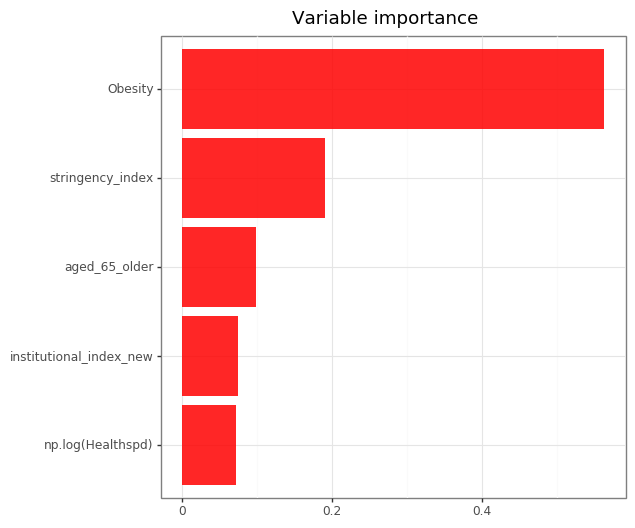

<ggplot: (-9223371923800832985)>

In [69]:
(pd.DataFrame(dict(variable = X.design_info.column_names, importance = rf.feature_importances_))
   .pipe(lambda _: ggplot(_, aes(x = "reorder(variable, importance)" , y = "importance")) +
                       geom_col(alpha = 0.85, fill = "Red") +
                       labs(x = "", y = "", title = "Variable importance") +
                       coord_flip() +
                       theme(legend_position = "none", figure_size = (6, 6))))

Nesse modelo mais simples de Random Forest, a obesidade é a variável mais importante.

# Árvore de Regressão

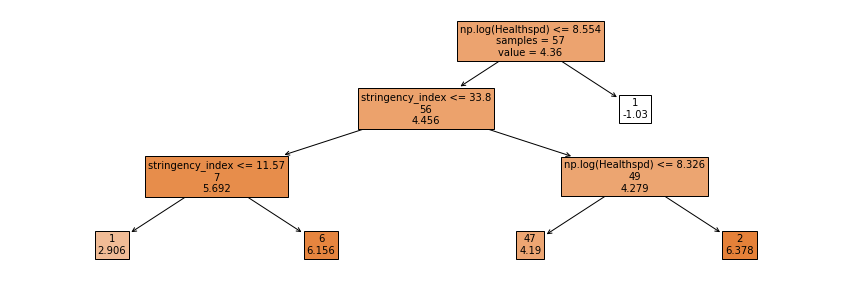

In [41]:
rtree = tree.DecisionTreeRegressor(max_depth = 3).fit(X_trn, y_tst)

plt.figure(figsize = (15, 5))
tree.plot_tree(rtree,
               feature_names = X.design_info.column_names,
               label = "root",
               filled = True,
               impurity = False, 
               fontsize = 10);

In [46]:
y_hat_tree = rtree.predict(X_tst)

RMSE = np.sqrt(mean_squared_error(y_tst, y_hat_tree))

print(np.round(RMSE, 2))

2.42


A árvore teve uma perfomance pior do que a random forest